# Metagenomics classifier generalization

### Главная идея
Современные классификаторы полных геномов НИКОГДА не могут оценить реальное количество - не то что организма, а даже количества прочтений в метагеноме.

К тому же, их результаты не всегда сходятся. Что же делать?

--

**Voting + GLM**

- [Объединяем результаты различных аннотаторов в одну таблицу:](https://colab.research.google.com/drive/1fu-vQOSNFS2aapMPB-3x8XIRpAYlKvtg#scrollTo=l6UwkDBDWWDs)

- Накидываем сверху классификатор

- По полученным классификациям фитим реальный многомерный glm видов

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import math

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

## Импорт

["Детский" пример](https://drive.google.com/file/d/1a3jHtgWYEKb_Gy6u9VOnAxyOW_KLgc0h/view?usp=drive_link)

[Искусственные данные для теста модели](https://drive.google.com/file/d/1RNaLFxGUzeEd72hSmRApFejeUqttYLAO/view?usp=sharing)

Данные для эвалюирования: в работе



In [ ]:
# !wget -O df.csv -r 'https://drive.usercontent.google.com/download?id=1a3jHtgWYEKb_Gy6u9VOnAxyOW_KLgc0h'
!wget -O df.csv -r 'https://drive.usercontent.google.com/download?id=1RMFoU2PndGIL5WcCCyesrK3mexnxGnSr'
!echo -e "\n\n####\n"
!head df.csv

will be placed in the single file you specified.

--2024-09-25 11:26:57--  https://drive.usercontent.google.com/download?id=1RMFoU2PndGIL5WcCCyesrK3mexnxGnSr
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.152.132, 2607:f8b0:4001:c56::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.152.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525061 (513K) [application/octet-stream]
Saving to: ‘df.csv’

df.csv              100%[===================>] 512.75K  --.-KB/s    in 0.009s  

2024-09-25 11:26:59 (56.4 MB/s) - ‘df.csv’ saved [525061/525061]

FINISHED --2024-09-25 11:26:59--
Total wall clock time: 2.6s
Downloaded: 1 files, 513K in 0.009s (56.4 MB/s)


####

"ann1","ann2","ann3","ann4","ann5","ann6","ann7","length","true"
"id73","id90","id10","id12","id12","0","id85",134,"id12"
"0","0","0","id99","0","0","id75",150,"id75"
"0","0","id17","id49","id54","id17","id25",154,"id17"
"id11","0","0","id

In [ ]:
df = pd.read_table("df.csv", sep=",")
df.head()
df.tail()

id_and_len = {}
all_id = [i for i in df[df.columns[8]]]
all_len = [i for i in df[df.columns[7]]]

for i in range(len(all_id)):
  id_and_len[all_id[i]] = all_len[i]

## Clear data.frame to import for ML

In [ ]:
df_clear = df.copy()
if "seq" == df_clear.columns[0]:
  df_clear = df_clear.drop("seq", axis = 1)
df_clear.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,length,true
0,id73,id90,id10,id12,id12,0,id85,134,id12
1,0,0,0,id99,0,0,id75,150,id75
2,0,0,id17,id49,id54,id17,id25,154,id17
3,id11,0,0,id13,id12,id99,id48,115,id13
4,id88,0,0,id99,id12,0,id43,44,id99


In [ ]:
df_tree = df_clear.apply(LabelEncoder().fit_transform)
target = "true"
df_tree.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,length,true
0,72,91,2,4,5,0,85,99,4
1,0,0,0,99,0,0,74,115,73
2,0,0,10,44,51,10,19,119,9
3,4,0,0,5,5,100,44,80,5
4,88,0,0,99,5,0,39,9,99


In [ ]:
categorical_columns_subset = df.columns[1:4]
numerical_columns_subset = "length"

y = df_clear["true"]

X = df_clear.loc[:, [*categorical_columns_subset, numerical_columns_subset] ]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")
X_NT=pd.get_dummies(X,columns=categorical_columns_subset,drop_first=False)
X_NT.head()

,length,ann2_0,ann2_id1,ann2_id10,ann2_id100,ann2_id11,ann2_id12,ann2_id13,ann2_id14,ann2_id15,...,ann4_id90,ann4_id91,ann4_id92,ann4_id93,ann4_id94,ann4_id95,ann4_id96,ann4_id97,ann4_id98,ann4_id99
0,134,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,150,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,154,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,115,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,44,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Desision tree

In [ ]:
X_T=df_tree.drop(target, axis = 1)
idx = list( range(0, len(X_T) ) )

X_T_train, X_T_test, y_train, y_test, idx_train, idx_test = model_selection.train_test_split(X_T, y, idx)

clfDTC=DecisionTreeClassifier(criterion="entropy")
clfDTC.fit(X_T_train,y_train)
y_pred=clfDTC.predict(X_T_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         id1       0.67      0.40      0.50        25
        id10       0.57      0.50      0.53         8
       id100       0.56      0.44      0.49        43
        id11       0.67      0.53      0.59        19
        id12       0.50      0.47      0.49        36
        id13       0.65      0.65      0.65        46
        id14       0.00      0.00      0.00         3
        id15       0.53      0.50      0.51        20
        id17       0.70      0.78      0.74         9
        id18       0.46      0.54      0.50        35
        id19       0.62      0.50      0.55        16
         id2       0.65      0.60      0.63        43
        id20       0.60      0.67      0.63         9
        id21       0.60      0.60      0.60        15
        id22       0.52      0.43      0.47        30
        id23       0.62      0.67      0.64        42
        id24       0.64      0.68      0.66        40
        id25       0.61    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
df_GLM = df_clear.loc[idx_test, :].drop("length", axis = 1).astype("category")
df_GLM["pred"] = y_pred

In [ ]:
df_GLM.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,true,pred
724,id6,0,0,id63,0,0,id58,id63,id63
3843,id34,0,id28,id28,id33,id30,id48,id28,id28
6381,id41,0,id46,id95,0,id36,id64,id61,id95
2853,id26,0,id26,id26,0,id26,id75,id26,id26
2050,id28,0,id75,id2,id2,0,id46,id2,id2


## GLM prepare

Задача: по полученным данным уточнить реальные количества. То есть для создания модели могут использоваться ТОЛЬКО предсказанные данные. Универсальность предсказания и саму модель можно проверять на разных `train_test_split`.

Алгоритм должен быть универсальным и принимать на вход любое количество строк и столбцов, и сам оптимизировать модели.

В `toy_example.csv`, очевидно, результат может быть достигнут простой пропорцией, и моделирование здесь не нужно. В остальных случаях требуется более сложная аппроксимация: за реальную численность одного таксона может отвечать численность многих таксонов с некоторыми вероятностями.

Построить минимум для toy_example, и разработать минимальный фит для искусственных данных. Этого вместе уже хватит, чтобы написать тезисы

In [ ]:
for i in df_GLM.copy().drop("true", axis = 1).columns:
  htm = pd.DataFrame([df_GLM.loc[j,i] == df_GLM.loc[j,"true"] for j in idx_test]).value_counts()

  tn = 0
  try:
    fn = pd.DataFrame([df_GLM.loc[j,i] == "0" for j in idx_test]).value_counts()[True]
  except:
    fn = 0

  tp = htm[True]
  fp = htm[False]-fn

  prec = tp/(fp+tp)
  rec = tp /(fn+tp)
  print(i)
  print("Precision:", round(prec,2))
  print("Recall:", round(rec,2))
  print("FN rate:", round(fn/len(df_GLM), 2))
  print("\n####\n")

ann1
Precision: 0.49
Recall: 0.51
FN rate: 0.32

####

ann2
Precision: 0.03
Recall: 0.0
FN rate: 0.89

####

ann3
Precision: 0.65
Recall: 0.67
FN rate: 0.25

####

ann4
Precision: 0.68
Recall: 1.0
FN rate: 0.0

####

ann5
Precision: 0.29
Recall: 0.33
FN rate: 0.37

####

ann6
Precision: 0.51
Recall: 0.55
FN rate: 0.3

####

ann7
Precision: 0.06
Recall: 0.58
FN rate: 0.04

####

pred
Precision: 0.55
Recall: 1.0
FN rate: 0.0

####



In [ ]:
df_taxid = pd.DataFrame()
for col in df_GLM.columns:
  df_taxid[col] = df_GLM[col].value_counts()


'''
df_taxid.insert(7, 'lenght', df[df.columns[7]])
for i in df_taxid.rows[::]:
  print(0)
df_taxid'''

df_taxid

# print(df[df.columns[7]][0])

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,true,pred
ann1,,,,,,,,,
0,799,2226.0,615,NaN,924,748,112,NaN,NaN
id62,33,3.0,31,41.0,19,22,19,51.0,47.0
id4,30,3.0,30,32.0,43,40,27,43.0,42.0
id44,30,4.0,29,40.0,17,42,21,47.0,56.0
id39,29,4.0,31,45.0,16,35,25,46.0,48.0
...,...,...,...,...,...,...,...,...,...
id81,7,3.0,10,13.0,12,13,22,6.0,13.0
id76,7,4.0,9,19.0,18,10,34,7.0,4.0
id16,7,3.0,8,7.0,10,7,23,NaN,NaN


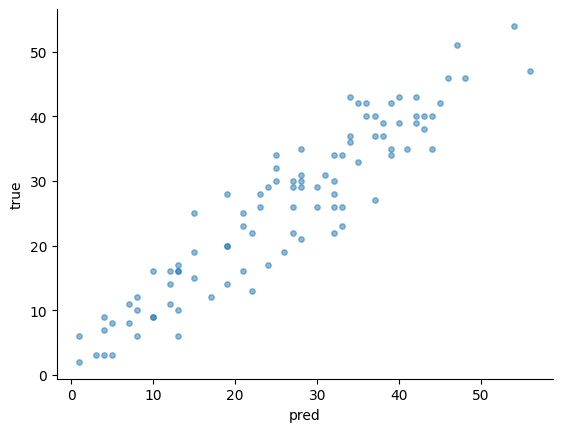

In [ ]:
df_taxid.plot(kind='scatter', x='pred', y='true', s=15, alpha=.5)
plt.gca().spines[['top', 'right',]].set_visible(False)

А дальше - наконец-то -
## GLM!

In [ ]:
curr = [] # массив со значениями pred, true, id, len
ind = 0
for i in df_taxid.values[::]:
  if math.isnan(i[-1]) or math.isnan(i[-2]): # избавляемся от NaN
    ind += 1
    continue
  curr.append([i[-1], i[-2], df_taxid.index[ind], id_and_len[df_taxid.index[ind]]])
  ind += 1


print(curr)

'''
print(curr)
X = np.array(curr)
# y = 0.90913227 * x_0 + 1 * x_1
y = np.dot(X, np.array([0.90913227, 1]))
reg = LinearRegression().fit(X, y) # регрессия
print(reg.coef_)'''

'''
print(np.corrcoef([i[0] for i in curr], [i[1] for i in curr])) # коэффициент корреляции
for i in range(len(curr)):
  curr[i][1] *= 100
print(curr)
print(np.corrcoef([i[0] for i in curr], [i[1] for i in curr])) # коэффициент корреляции с умножением на коэффициент'''


reg = linear_model.LinearRegression()
reg.fit([[i[0]] for i in curr], [i[1] for i in curr])
print(reg.coef_)
print(reg.intercept_)

mean_tg = sum([i[1] / i[0] for i in curr]) / len(curr) # средний тангенс точек
print(mean_tg)
MAE_tg = sum([abs(i[1] - mean_tg * i[0]) for i in curr]) / len(curr)
MAE_regression = sum([abs(i[1] - 0.9125844 * i[0] - 2.2451980133837424) for i in curr]) / len(curr)
print(MAE_tg, MAE_regression)

[[47.0, 51.0, 'id62', 64], [42.0, 43.0, 'id4', 143], [56.0, 47.0, 'id44', 109], [48.0, 46.0, 'id39', 152], [39.0, 42.0, 'id79', 71], [23.0, 28.0, 'id46', 180], [40.0, 39.0, 'id47', 220], [54.0, 54.0, 'id71', 183], [43.0, 38.0, 'id90', 138], [40.0, 43.0, 'id2', 183], [25.0, 34.0, 'id52', 136], [42.0, 39.0, 'id83', 189], [42.0, 40.0, 'id24', 132], [33.0, 34.0, 'id8', 201], [28.0, 30.0, 'id95', 44], [43.0, 40.0, 'id91', 103], [37.0, 40.0, 'id64', 77], [44.0, 40.0, 'id29', 121], [35.0, 42.0, 'id97', 128], [33.0, 23.0, 'id84', 80], [39.0, 35.0, 'id43', 159], [38.0, 39.0, 'id7', 37], [27.0, 30.0, 'id68', 142], [37.0, 27.0, 'id50', 163], [25.0, 30.0, 'id22', 61], [38.0, 37.0, 'id80', 47], [22.0, 13.0, 'id31', 51], [32.0, 34.0, 'id51', 81], [24.0, 29.0, 'id34', 117], [21.0, 23.0, 'id36', 131], [12.0, 11.0, 'id30', 133], [35.0, 33.0, 'id61', 125], [19.0, 28.0, 'id70', 126], [32.0, 26.0, 'id87', 107], [25.0, 32.0, 'id41', 38], [28.0, 21.0, 'id94', 127], [36.0, 42.0, 'id53', 78], [41.0, 35.0, 'id

Преобразование данных на основании регрессии

In [ ]:
d = {'id' : [i[2] for i in curr], 'len' : [i[3] for i in curr], 'true' : [i[1] for i in curr], 'pred' : [i[0] for i in curr], 'reg+pred' : [i[0] * mean_tg for i in curr]}
df_reg = pd.DataFrame(data=d)
df_reg

,id,len,true,pred,reg+pred
0,id62,64,51.0,47.0,51.867841
1,id4,143,43.0,42.0,46.349985
2,id44,109,47.0,56.0,61.799980
3,id39,152,46.0,48.0,52.971412
4,id79,71,42.0,39.0,43.039272
...,...,...,...,...,...
91,id99,156,14.0,12.0,13.242853
92,id78,138,8.0,5.0,5.517855
93,id81,155,6.0,13.0,14.346424
94,id76,155,7.0,4.0,4.414284


In [ ]:
print([(i[0], i[1]) for i in curr])
print([(i[0], i[1]) for i in curr if i[3] <= 104])
print([(i[0], i[1]) for i in curr if 104 < i[3] <= 154])
print([(i[0], i[1]) for i in curr if 154 < i[3]])

mean_tg_1 = sum([i[1] / i[0] for i in curr if i[3] <= 104]) / len([i for i in curr if i[3] <= 104]) # средний тангенс точек 1.012833671998631
print(mean_tg_1)
mean_tg_2 = sum([i[1] / i[0] for i in curr if 104 < i[3] <= 154]) / len([i for i in curr if 104 < i[3] <= 154]) # средний тангенс точек 1.102737781758341
print(mean_tg_2)
mean_tg_3 = sum([i[1] / i[0] for i in curr if 154 < i[3]]) / len([i for i in curr if 154 < i[3]]) # средний тангенс точек 1.1219641182898248
print(mean_tg_3)



[(47.0, 51.0), (42.0, 43.0), (56.0, 47.0), (48.0, 46.0), (39.0, 42.0), (23.0, 28.0), (40.0, 39.0), (54.0, 54.0), (43.0, 38.0), (40.0, 43.0), (25.0, 34.0), (42.0, 39.0), (42.0, 40.0), (33.0, 34.0), (28.0, 30.0), (43.0, 40.0), (37.0, 40.0), (44.0, 40.0), (35.0, 42.0), (33.0, 23.0), (39.0, 35.0), (38.0, 39.0), (27.0, 30.0), (37.0, 27.0), (25.0, 30.0), (38.0, 37.0), (22.0, 13.0), (32.0, 34.0), (24.0, 29.0), (21.0, 23.0), (12.0, 11.0), (35.0, 33.0), (19.0, 28.0), (32.0, 26.0), (25.0, 32.0), (28.0, 21.0), (36.0, 42.0), (41.0, 35.0), (28.0, 35.0), (30.0, 29.0), (30.0, 26.0), (36.0, 40.0), (15.0, 25.0), (15.0, 15.0), (28.0, 31.0), (28.0, 29.0), (10.0, 16.0), (19.0, 20.0), (7.0, 11.0), (34.0, 37.0), (33.0, 26.0), (22.0, 22.0), (17.0, 12.0), (44.0, 35.0), (45.0, 42.0), (24.0, 17.0), (19.0, 14.0), (1.0, 6.0), (46.0, 46.0), (32.0, 22.0), (4.0, 9.0), (34.0, 43.0), (32.0, 28.0), (39.0, 34.0), (27.0, 22.0), (21.0, 25.0), (34.0, 36.0), (32.0, 30.0), (15.0, 19.0), (37.0, 37.0), (8.0, 12.0), (13.0, 17.0

подсчет R2

In [ ]:
print(r2_score([i[1] for i in curr], [i[0] for i in curr])) # R2 без регрессии
print(r2_score([i[1] for i in curr], [i[0] * 0.85081622 + 3.890748993085527 for i in curr])) # R2 и регрессия со свободным членом

updated_pred = []
for i in curr:
  if i[3] <= 104:
    updated_pred.append((i[0] * 1.012833671998631, i[1])) # i[0] - predicted value
  # elif 104 < i[3] <= 154:
    # updated_pred.append((i[0] * 1.102737781758341, i[1]))
  else:
    updated_pred.append((i[0] * 1.1219641182898248, i[1]))
print(r2_score([i[1] for i in updated_pred], [i[0] for i in updated_pred])) # R2 с регрессией без свободного члена


0.865543247938781
0.8741632582187651
0.7852072414626432


регрессия с отделением коротких прочтений

In [ ]:
short_filter = 104
reg_short = linear_model.LinearRegression()
reg_short.fit([[i[0]] for i in curr if i[3] < short_filter], [i[1] for i in curr if i[3] < short_filter])
print(reg_short.coef_)
print(reg_short.intercept_)

reg_long = linear_model.LinearRegression()
reg_long.fit([[i[0]] for i in curr if i[3] >= short_filter], [i[1] for i in curr if i[3] >= short_filter])
print(reg_long.coef_)
print(reg_long.intercept_)

long_short_updated_pred = []
for i in curr:
  if i[3] <= 104:
    long_short_updated_pred.append((i[0] * 0.82229386 + 5.7881713108607755, i[1])) # i[0] - predicted value
  # elif 104 < i[3] <= 154:
    # updated_pred.append((i[0] * 1.102737781758341, i[1]))
  else:
    long_short_updated_pred.append((i[0] * 0.88626499 + 2.4476054829839278, i[1]))
print(r2_score([i[1] for i in long_short_updated_pred], [i[0] for i in long_short_updated_pred]))

[0.92988062]
2.4605785915439498
[0.88502077]
2.622140359933365
0.8758895586405717


<ipython-input-25-d4198a73b34b>:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([i[0] for i in curr if i[3] < 104], [i[1] for i in curr if i[3] < 104], c=[100, 100, 100])


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 32.

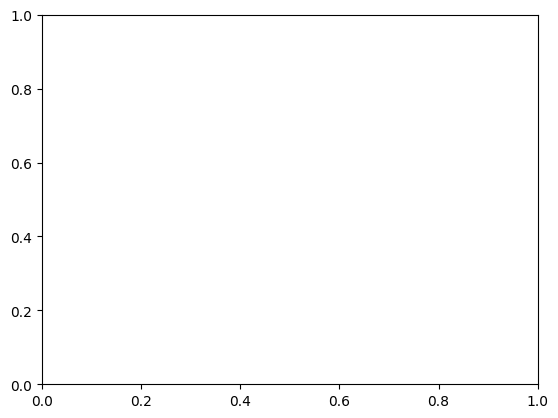

In [ ]:
plt.scatter([i[0] for i in curr if i[3] < 104], [i[1] for i in curr if i[3] < 104], c=[100, 100, 100])


# ---- To implement

## HGBR

In [ ]:
hist_native = HistGradientBoostingRegressor()
hist_native.fit(X_NT,y)

In [ ]:
scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

HGBR_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)